## Getting Started with CUDA

In [1]:
!pip install ninja

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 6.6 MB/s eta 0:00:00


In [2]:
import math
import os
!rm -rf /root/.cache/torch_extensions/
import torch
import torchvision

import matplotlib.pyplot as plt

from torchvision import io
from torch.utils.cpp_extension import load_inline

In [3]:
img = io.read_image("toffee.jpg")
print(img.shape)
img[:3, :3, :4]

torch.Size([3, 4032, 3024])


tensor([[[203, 200, 199, 199],
         [204, 201, 198, 198],
         [204, 201, 199, 199]],

        [[167, 164, 163, 163],
         [168, 165, 162, 162],
         [168, 165, 163, 163]],

        [[119, 116, 115, 115],
         [120, 117, 114, 114],
         [120, 117, 115, 115]]], dtype=torch.uint8)

In [4]:
def show_img(x, figsize=(4, 3), **kwargs):
    plt.figure(figsize=figsize)
    plt.axis("off")
    if len(x.shape) == 3:
        x = x.permute(1, 2, 0) # CHW -> HWC  PyTorch (CHW - Channels, Height, Width) -> matplotlib (HWC - Height, Width, Channels)
    plt.imshow(x.cpu(), **kwargs)

In [5]:
img2 = torchvision.transforms.functional.resize(img, 150, antialias=True)
ch, h, w = img2.shape
print(ch, h, w, h*w)

3 200 150 30000


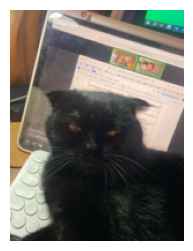

In [6]:
show_img(img2)

### RGB -> Gray

#### Basic Python

In [7]:
def rgb2grey_py(img):
    channels, height, width = img.shape
    N = height * width  # Flatten 2D matrix size
    img = img.flatten()
    res = torch.empty(N, dtype=img.dtype, device=img.device)
    for i in range(N):
        res[i] = 0.2989 * img[i] + 0.5870 * img[i + N] + 0.1140 * img[i + 2 * N]
    return res.view(height, width)

In [8]:
%%time
img_g = rgb2grey_py(img2)

CPU times: user 1.73 s, sys: 0 ns, total: 1.73 s
Wall time: 2.33 s


In [9]:
img_g.shape

torch.Size([200, 150])

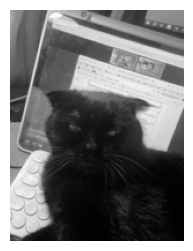

In [10]:
show_img(img_g, cmap="gray")

#### Python Kernel

In [11]:
# A kernel can not return anything. It can only change contents of things passed to it.
def run_kernel(f, times, *args):
    for i in range(times):
        f(i, *args)

In [12]:
def rgb2grey_k(i, img, out, N):
    out[i] = 0.2989 * img[i] + 0.5870 * img[i + N] + 0.1140 * img[i + 2 * N]

In [13]:
def rgb2grey_pyk(img):
    channels, height, width = img.shape
    N = height * width
    img = img.flatten()
    res = torch.empty(N, dtype=img.dtype, device=img.device)
    run_kernel(rgb2grey_k, N, img, res, N)
    return res.view(height, width)

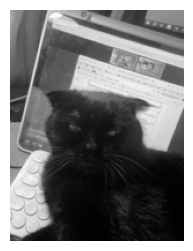

In [14]:
img_g = rgb2grey_pyk(img2)
show_img(img_g, cmap="gray")

#### Python Block Kernel
- **Streaming Multiprocessors (SMs):** In NVIDIA GPUs, SMs are the fundamental units of execution. Each SM can execute multiple threads concurrently.
- **Thread Blocks:** A thread block is a group of threads that can cooperate among themselves through shared memory and synchronization. All threads in a block are executed on the same SM. This means they can share resources such as shared memory and can synchronize their execution with each other.
- **Shared Memory:** Shared memory is a small memory space on the GPU that is shared among the threads in a block. It is much faster than global memory (the main GPU memory), but it is also limited in size. Threads in the same block can use shared memory to share data with each other efficiently.
- The RTX 3090, based on the Ampere architecture, has 82 SMs.
- Each SM in GA10x GPUs contain 128 CUDA Cores, four third-generation Tensor Cores, a 256 KB Register File, and 128 KB of L1/Shared Memory
- In CUDA, all threads in a block have the potential to run concurrently. However, the actual concurrency depends on the number of CUDA cores per SM and the resources required by the threads.

In [15]:
def blk_kernel(f, blocks, threads, *args):
    for i in range(blocks):
        for j in range(threads):
            f(i, j, threads, *args)

In [16]:
def rgb2gray_bk(blockIdx, threadIdx, blockDim, img, out, N):
    i = blockIdx * blockDim + threadIdx
    if i < N:
        out[i] = 0.2989 * img[i] + 0.5870 * img[i + N] + 0.1140 * img[i + 2 * N]

In [17]:
def rgb2gray_pybk(img):
    channels, height, width = img.shape
    N = height * width
    img = img.flatten()
    res = torch.empty(N, dtype=img.dtype, device=img.device)
    threads = 256
    blocks = int(math.ceil(height * width / threads))
    blk_kernel(rgb2gray_bk, blocks, threads, img, res, N)
    return res.view(height, width)

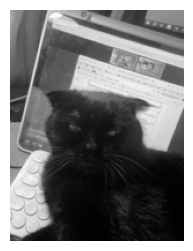

In [18]:
img_g = rgb2gray_pybk(img2)
show_img(img_g, cmap="gray")

#### CUDA

In [19]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"  # Используем только для отладки

In [20]:
# Для захвата и отображения C-level вывода (stdout/stderr) из низкоуровневых библиотек
%load_ext wurlitzer

In [21]:
def load_cuda(cuda_src, cpp_src, funcs, opt=False, verbose=False):
    return load_inline(
        cuda_sources=[cuda_src],
        cpp_sources=[cpp_src],
        functions=funcs,
        extra_cuda_cflags=["-02"] if opt else [],
        verbose=verbose,
        name="inline_ext"
    )

In [22]:
cuda_begin = r'''
#include <torch/extension.h>
#include <stdio.h>
#include <c10/cuda/CUDAException.h>

#define CHECK_CUDA(img) TORCH_CHECK(img.device().is_cuda(), #img " must be a CUDA tensor")
#define CHECK_CONTIGUOUS(img) TORCH_CHECK(img.is_contiguous(), #img "must be contiguous")
#define CHECK_INPUT(img) CHECK_CUDA(img); CHECK_CONTIGUOUS(img)

inline unsigned int cdiv(unsigned int a, unsigned int b) { return (a + b - 1) / b;}
'''

#### CUDA Kernel

- 2^31 max blocks for dim0, 2^16 max for dim1 & dim2
- 1024 max threads per block (use a multiple of 32)
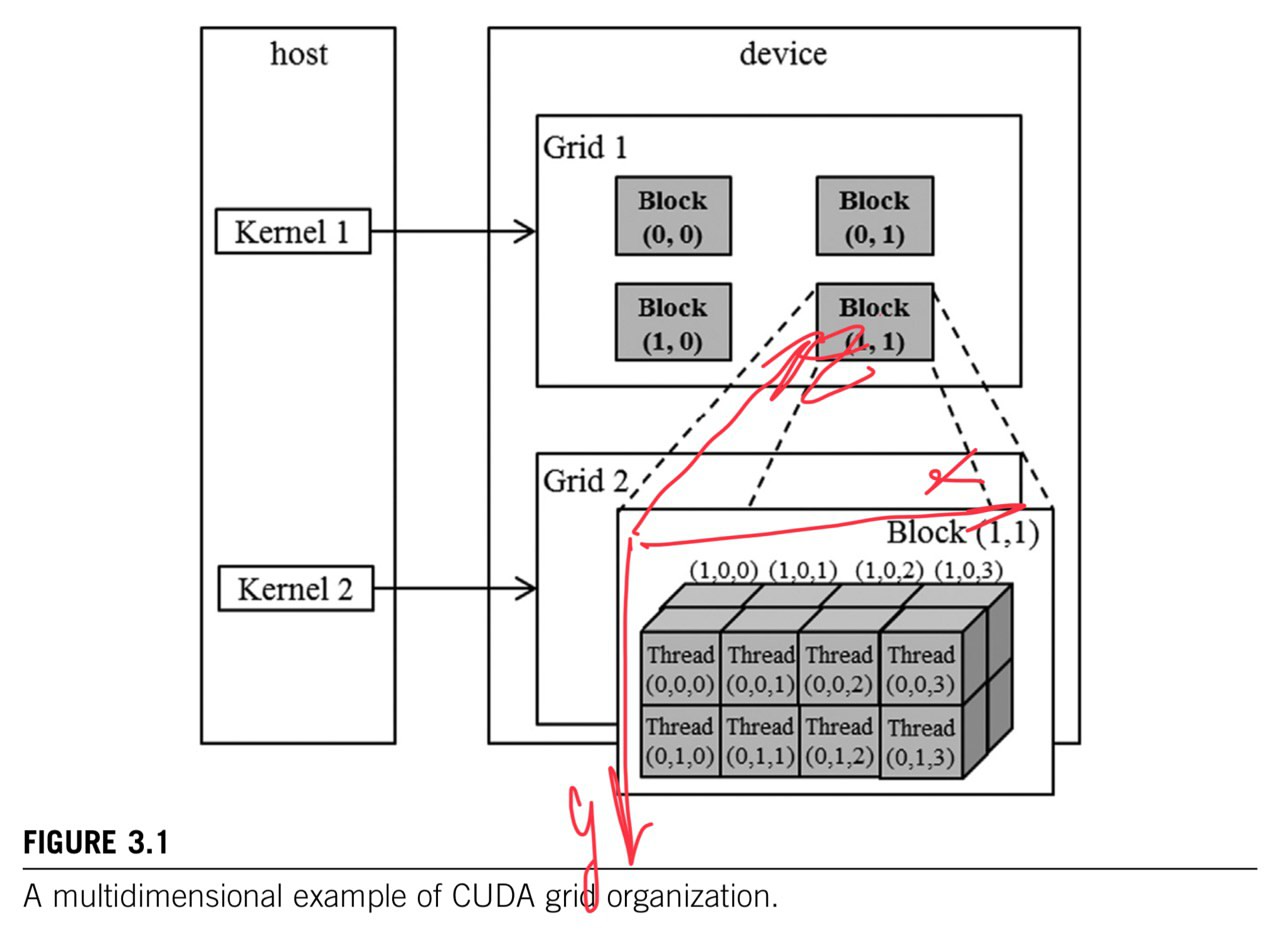

In [23]:
cuda_src = cuda_begin + r'''
__global__ void rgb_to_grayscale_kernel(unsigned char* img, unsigned char* out, int n) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i < n) {
        out[i] = 0.2989 * img[i] + 0.5870 * img[i + n] + 0.1140 * img[i + 2 * n];
    }
}

torch::Tensor rgb_to_grayscale(torch::Tensor input){
    CHECK_INPUT(input);
    int height = input.size(1);
    int width = input.size(2);
    printf("height * width: %d%d\n", height, width);
    auto output = torch::empty({height, width}, input.options());
    int threads = 256;
    rgb_to_grayscale_kernel<<<cdiv(height * width, threads), threads>>>(
        input.data_ptr<unsigned char>(), output.data_ptr<unsigned char>(), height * width
    );
    C10_CUDA_KERNEL_LAUNCH_CHECK(); /// Отлавливаем ошибки CUDA
    return output;
}
'''

In [24]:
cpp_src = "torch::Tensor rgb_to_grayscale(torch::Tensor input);"

In [25]:
module = load_cuda(cuda_src, cpp_src, ['rgb_to_grayscale'], verbose=True)

W0922 18:21:14.245000 1339 torch/utils/cpp_extension.py:2425] TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
W0922 18:21:14.245000 1339 torch/utils/cpp_extension.py:2425] If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'] to specific architectures.


[1/3] c++ -MMD -MF main.o.d -DTORCH_EXTENSION_NAME=inline_ext -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1018\" -isystem /usr/local/lib/python3.12/dist-packages/torch/include -isystem /usr/local/lib/python3.12/dist-packages/torch/include/torch/csrc/api/include -isystem /usr/local/cuda/include -isystem /usr/include/python3.12 -fPIC -std=c++17 -c /root/.cache/torch_extensions/py312_cu126/inline_ext/main.cpp -o main.o 
[2/3] /usr/local/cuda/bin/nvcc --generate-dependencies-with-compile --dependency-output cuda.cuda.o.d -DTORCH_EXTENSION_NAME=inline_ext -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1018\" -isystem /usr/local/lib/python3.12/dist-packages/torch/include -isystem /usr/local/lib/python3.12/dist-packages/torch/include/torch/csrc/api/include -isystem /usr/local/cuda/include -isystem /usr/include/python3.12 -D__CUD

In [26]:
dir(module)

['__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'rgb_to_grayscale']

In [27]:
%%time
res = module.rgb_to_grayscale(img.contiguous().cuda()).cpu()
height, width = res.shape
height, width, height * width

height * width: 40323024
CPU times: user 73.8 ms, sys: 89.8 ms, total: 164 ms
Wall time: 204 ms


(4032, 3024, 12192768)

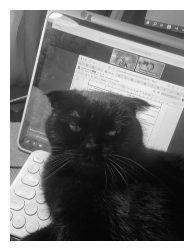

In [28]:
show_img(res, cmap="gray")

### Matmul

#### Get Data

In [29]:
import pickle
import gzip

from urllib.request import urlretrieve
from pathlib import Path
from torch import tensor
from tqdm import tqdm

In [30]:
MNIST_URL = "https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true"
path_data = Path("data")
path_data.mkdir(exist_ok=True)
path_gz = path_data / "mnist.pkl.gz"

if not path_gz.exists():
    urlretrieve(MNIST_URL, path_gz)

In [31]:
with gzip.open(path_gz, 'rb') as f:
     ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

x_train, y_train, x_valid, y_valid = map(tensor, (x_train, y_train, x_valid, y_valid))

x_train.shape, x_train.type()

(torch.Size([50000, 784]), 'torch.FloatTensor')

In [32]:
imgs = x_train.reshape((-1,28,28))
imgs.shape

torch.Size([50000, 28, 28])

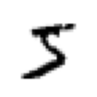

In [33]:
show_img(imgs[0], cmap="gray_r", figsize=(1,1))

In [34]:
torch.manual_seed(1)
weights = torch.randn(784, 10)
weights

tensor([[-1.5256, -0.7502, -0.6540,  ..., -1.6091, -0.7121,  0.3037],
        [-0.7773, -0.2515, -0.2223,  ..., -1.1608,  0.6995,  0.1991],
        [ 0.8657,  0.2444, -0.6629,  ..., -1.4465,  0.0612, -0.6177],
        ...,
        [ 0.5063,  0.4656, -0.2634,  ...,  0.6452,  0.4298, -1.2936],
        [ 0.5171,  1.0315,  0.8120,  ..., -0.1046,  2.2588, -0.2793],
        [-1.4899,  0.3898, -0.5454,  ..., -0.1923, -0.5076,  0.5439]])

#### Python matmul

In [35]:
m1 = x_valid[:500]
m2 = weights
m1.shape, m2.shape

(torch.Size([500, 784]), torch.Size([784, 10]))

In [36]:
def matmul(a, b):
    (ar, ac), (br, bc) = a.shape, b.shape
    c = torch.zeros(ar, bc)
    for i in tqdm(range(ar)):
        for j in range(bc):
            for k in range(ac):
                c[i, j] += a[i, k] * b[k, j]
    return c

In [37]:
%%time
t1 = matmul(m1, m2)

100%|██████████| 500/500 [01:48<00:00,  4.59it/s]

CPU times: user 1min 37s, sys: 615 ms, total: 1min 38s
Wall time: 1min 48s


#### Python block kernel

In [38]:
from types import SimpleNamespace as ns

def blk_kernel2d(f, blocks, threads, *args):
    for blockIdx_y in range(blocks.y):
        for blockIdx_x in range(blocks.x):
            for threadIdx_y in range(threads.y):
                for threadIdx_x in range(threads.x):
                    f(ns(x=blockIdx_x,y=blockIdx_y), ns(x=threadIdx_x,y=threadIdx_y), threads, *args)

In [39]:
def matmul_bk(blockidx, threadidx, blockdim, m, n, out, height, width, k):
    row = blockidx.y * blockdim.y + threadidx.y
    column = blockidx.x * blockdim.x + threadidx.x
    if (row >= height or column >= width):
        return
    o = 0.
    for i in range(k):
        o += m[row*k+i] * n[i*width+column]
    out[row*width+column] = o

In [40]:
def matmul_2d(m, n):
    height, k  = m.shape
    k2, width = n.shape
    assert k == k2, "Size mismatch!"
    output = torch.zeros(height, width, dtype=m.dtype)
    tpb = ns(x=32,y=32) # Размер блока
    blocks = ns(x=math.ceil(width/tpb.x), y=math.ceil(height/tpb.y))  # Размер сетки
    print("Grid Size:", blocks)
    blk_kernel2d(matmul_bk, blocks, tpb,
                 m.flatten(), n.flatten(), output.flatten(), height, width, k)
    return output

In [41]:
m1.shape, m2.shape

(torch.Size([500, 784]), torch.Size([784, 10]))

In [42]:
res = matmul_2d(m1, m2)

Grid Size: namespace(x=1, y=16)


In [43]:
res == t1

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])

#### Broadcasting

In [51]:
def mamtul(a, b):
    (ar, ac), (br, bc) = a.shape, b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):
        c[i] = (a[i, :, None] * b).sum(dim=0)
    return c

In [52]:
%time broad_res = matmul(m1, m2)

100%|██████████| 500/500 [01:26<00:00,  5.81it/s]

CPU times: user 1min 23s, sys: 307 ms, total: 1min 23s
Wall time: 1min 26s


In [55]:
torch.isclose(t1, broad_res).all()

tensor(True)

In [56]:
%time tr = matmul(x_train, m2)

100%|██████████| 50000/50000 [2:16:30<00:00,  6.10it/s]

CPU times: user 2h 15min 18s, sys: 26.8 s, total: 2h 15min 45s
Wall time: 2h 16min 30s


#### CUDA Matmul

In [57]:
cuda_src = cuda_begin + r'''
__global__ void matmul_k(float* m, float* n, float* out, int height, int width, int k) {
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int column = blockIdx.x * blockDim.x + threadIdx.x;

    if (row >= height || column >= width) {
        return;
    }
    float o = 0;
    for (int i = 0; i < k; ++i) {
        o += m[row * k + i] * n[i * width + column];
    }
    out[row * width + column] = o;
}

torch::Tensor matmul(torch::Tensor m, torch::Tensor n) {
    CHECK_INPUT(m);
    CHECK_INPUT(n);

    int height = m.size(0);
    int width = n.size(1);
    int k = m.size(1);
    TORCH_CHECK(k == n.size(0), "Size mismatch!");
    auto output = torch::zeros({height, width}, m.options());

    dim3 tpb(16,16);
    dim3 blocks(cdiv(width, tpb.x), cdiv(height, tpb.y));
    matmul_k<<<blocks, tpb>>>(
        m.data_ptr<float>(), n.data_ptr<float>(), output.data_ptr<float>(), height, width, k
    );
    C10_CUDA_KERNEL_LAUNCH_CHECK();
    return output;
}
'''

In [59]:
cpp_src = "torch::Tensor matmul(torch::Tensor m, torch::Tensor n);"

In [60]:
module = load_cuda(cuda_src, cpp_src, ["matmul"])

In [61]:
m2.shape

torch.Size([784, 10])

In [62]:
m1c, m2c = x_train.contiguous().cuda(), m2.contiguous().cuda()

In [63]:
torch.isclose(tr, module.matmul(m1c, m2c).cpu(), atol=1e-5).all()

tensor(True)

In [64]:
%%time
res=module.matmul(m1c, m2c).cpu()
res.shape

CPU times: user 5.59 ms, sys: 997 µs, total: 6.59 ms
Wall time: 6.18 ms


torch.Size([50000, 10])

#### Pytorch

In [69]:
%time _=(m1c@m2c).cpu()

CPU times: user 2.87 ms, sys: 0 ns, total: 2.87 ms
Wall time: 3.05 ms
